In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks")

In [2]:
# Opening and reading the file
av_acc = pd.read_csv("aviation-accidents.csv")
av_acc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23967 entries, 0 to 23966
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          23967 non-null  object
 1   type          23967 non-null  object
 2   registration  22419 non-null  object
 3   operator      23963 non-null  object
 4   fatalities    20029 non-null  object
 5   location      23019 non-null  object
 6   country       23967 non-null  object
 7   cat           23967 non-null  object
 8   year          23967 non-null  object
dtypes: object(9)
memory usage: 1.6+ MB


In [3]:
av_acc.isna().sum()

,0
date,0
type,0
registration,1548
operator,4
fatalities,3938
location,948
country,0
cat,0
year,0


In [4]:
# Dropping columns not useful for analysis
av_acc.drop("registration", axis=1, inplace=True)
av_acc.drop("location", axis=1, inplace=True)
av_acc.isna().sum()

,0
date,0
type,0
operator,4
fatalities,3938
country,0
cat,0
year,0


In [5]:
# Dropping invalid entries
av_acc.dropna(inplace=True)
av_acc.isna().sum()

,0
date,0
type,0
operator,0
fatalities,0
country,0
cat,0
year,0


In [6]:
# Filtering the date column and changing the format to datetime
mask_date_unknown = av_acc["date"] != "date unk."
mask_date_format = av_acc["date"].str.contains(r"\d{2}-[a-zA-Z]{3}-\d{4}", regex=True)
mask_date = mask_date_unknown & mask_date_format
av_acc = av_acc[mask_date]
av_acc["date"] = pd.to_datetime(av_acc["date"], format="%d-%b-%Y")
av_acc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19800 entries, 61 to 23966
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        19800 non-null  datetime64[ns]
 1   type        19800 non-null  object        
 2   operator    19800 non-null  object        
 3   fatalities  19800 non-null  object        
 4   country     19800 non-null  object        
 5   cat         19800 non-null  object        
 6   year        19800 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 1.2+ MB


In [7]:
# Cleaning the fatalities column and changing the format to int
av_acc["fatalities"] = av_acc["fatalities"].str.replace(r"(\d+)\s*\+\s*(\d+)", lambda m: str(int(m.group(1)) + int(m.group(2))), regex=True)

av_acc["fatalities"] = av_acc["fatalities"].astype(int)
av_acc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19800 entries, 61 to 23966
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        19800 non-null  datetime64[ns]
 1   type        19800 non-null  object        
 2   operator    19800 non-null  object        
 3   fatalities  19800 non-null  int64         
 4   country     19800 non-null  object        
 5   cat         19800 non-null  object        
 6   year        19800 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 1.2+ MB


In [8]:
# Grouping and filtering the country column
acc_per_country = av_acc.groupby(["country"])
acc_per_country = acc_per_country.size().sort_values(ascending=False)
mask_country_index = acc_per_country.index != "Unknown country"
acc_per_country = acc_per_country[mask_country_index]
acc_per_country

,0
country,
USA,3966
Russia,1284
Canada,791
U.K.,719
Brazil,573
...,...
Monaco,1
Reunion,1
Tuvalu,1


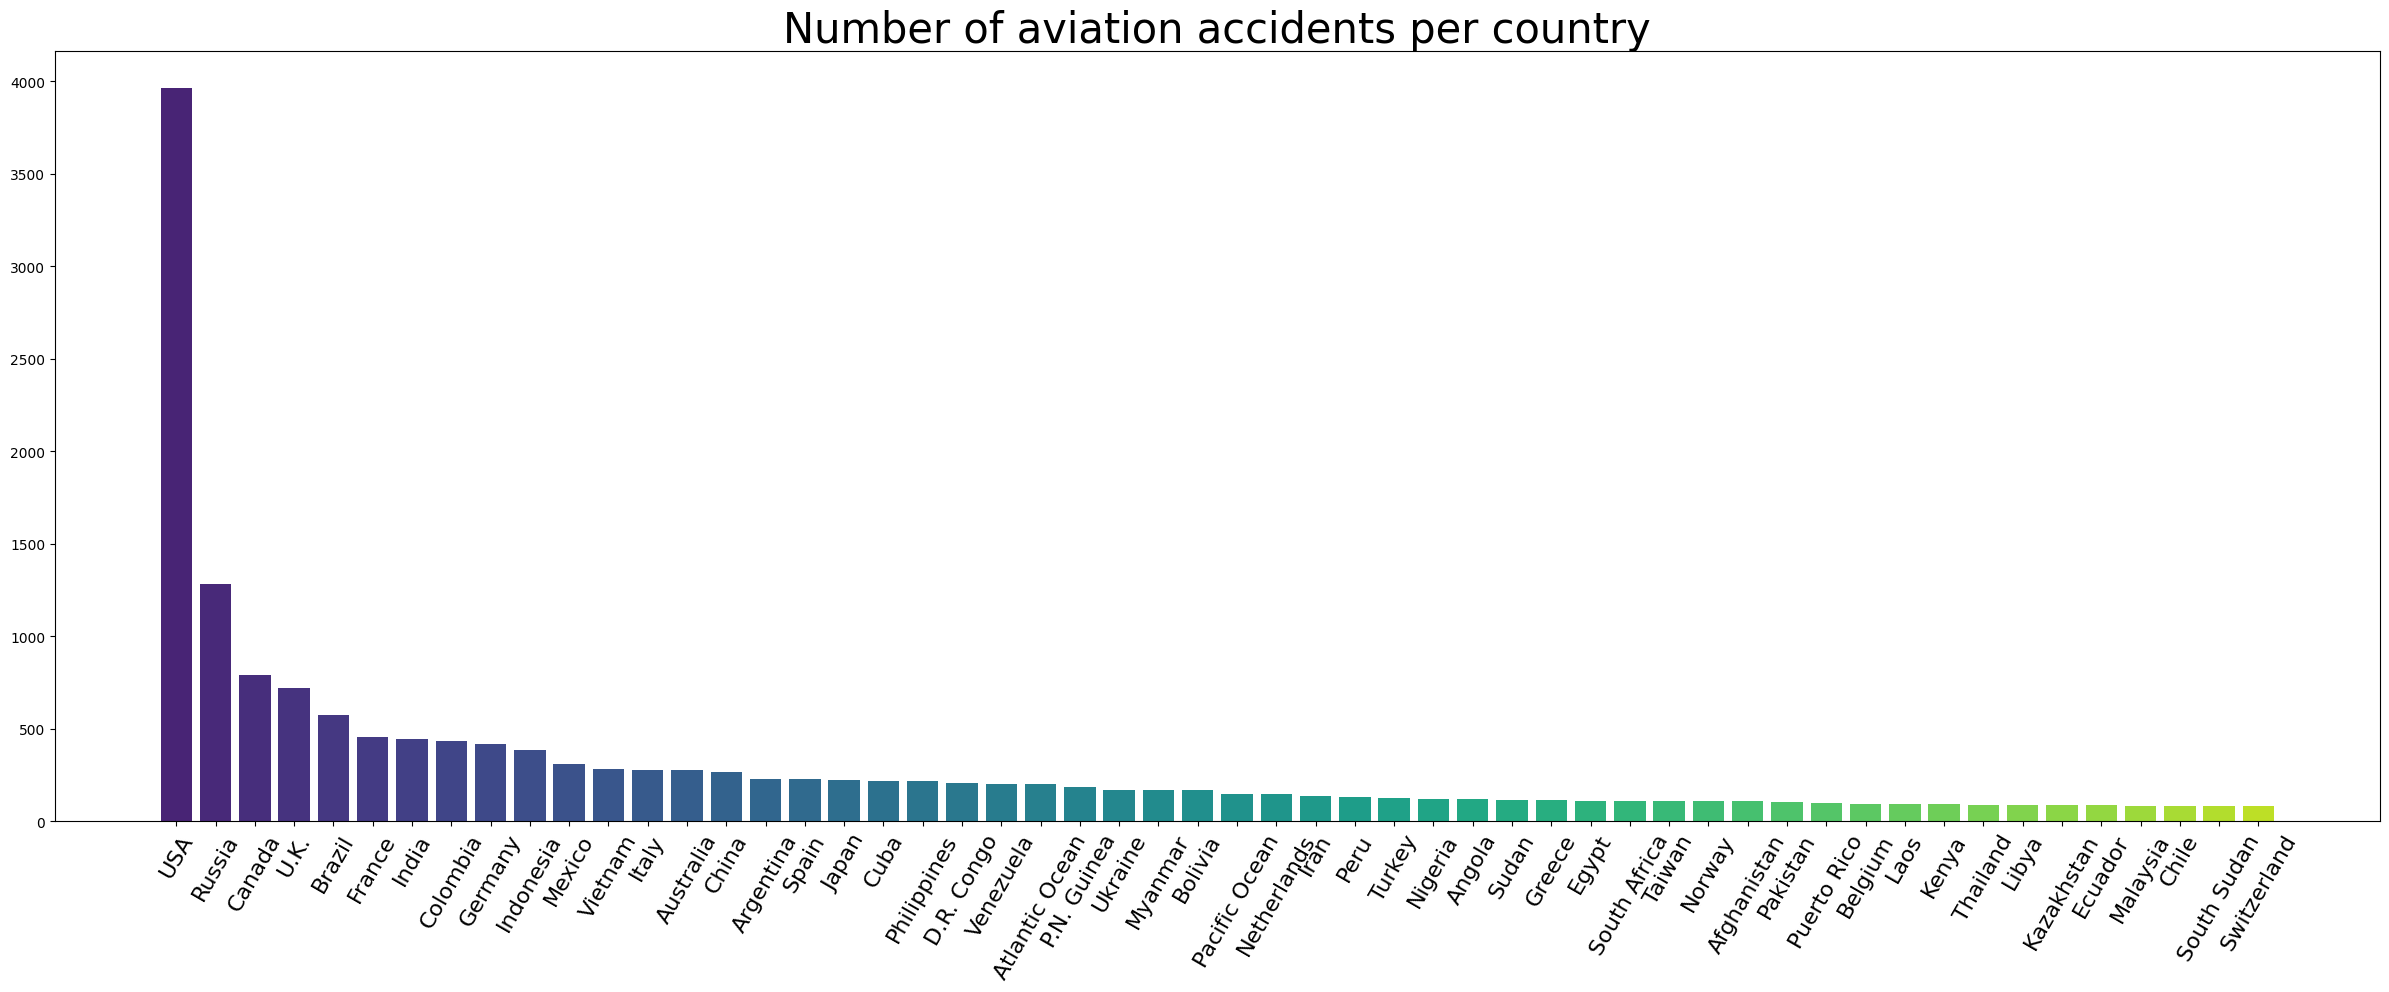

In [9]:
# Bar chart representing Number of aviation accidents per country, considering only countries with a relevant number of accidents
mask_country_index = acc_per_country.index != "Unknown country"
mask_country_values = acc_per_country.values>80
mask_country = mask_country_index & mask_country_values
acc_per_country = acc_per_country[mask_country]
viridis = plt.colormaps["viridis"]
plt.rcParams["figure.figsize"] = [30, 10]
plt.xticks(fontsize=16, rotation=60)
plt.title("Number of aviation accidents per country", fontsize=30)
plt.bar(acc_per_country.index, acc_per_country.values, color=viridis(np.linspace(0.1, 0.9, len(acc_per_country.index))))
plt.show()


In [10]:
# Grouping values by weekday
date = av_acc["date"]
weekdays = date.dt.day_name()
weekdays.value_counts()

,count
date,
Friday,3066
Wednesday,3006
Thursday,3002
Tuesday,2942
Monday,2806
Saturday,2656
Sunday,2322


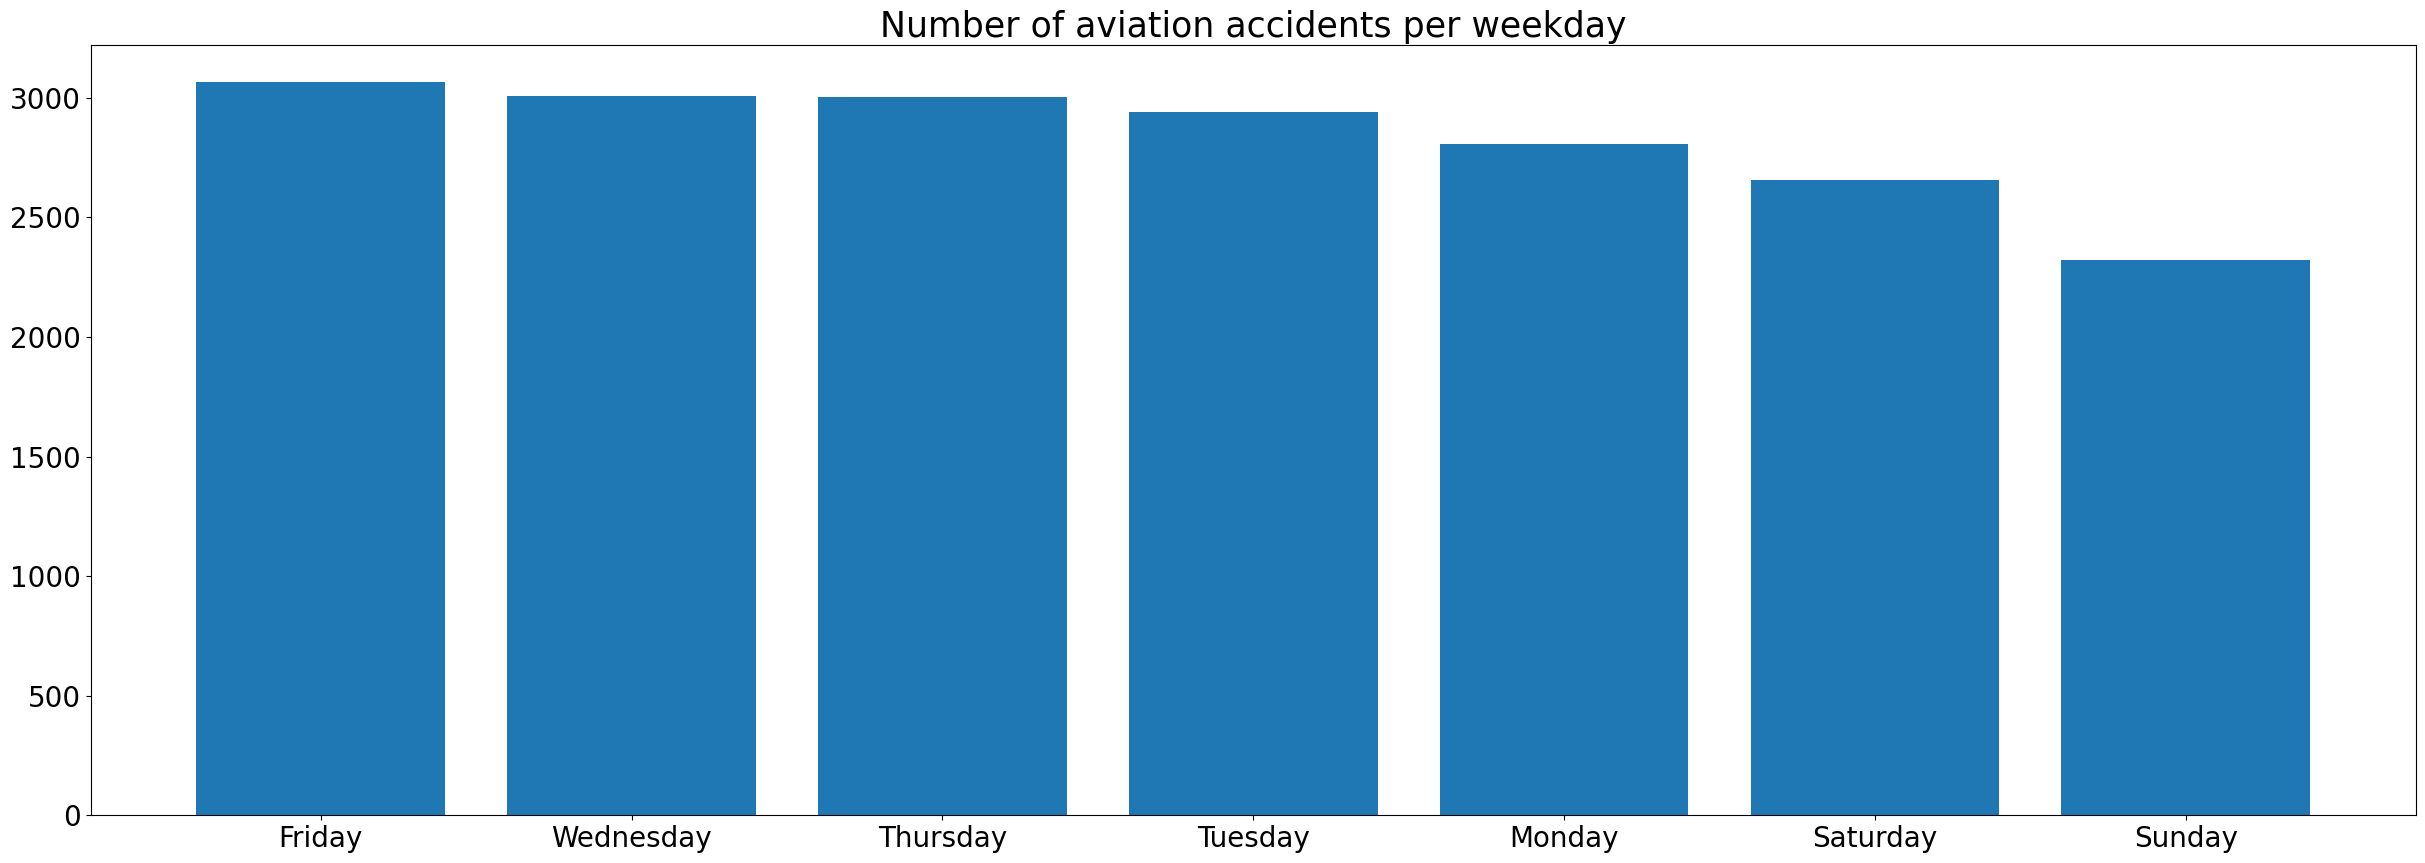

In [11]:
# Bar chart representing Number of aviation accidents per weekday
plt.bar(weekdays.value_counts().index, weekdays.value_counts().values)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Number of aviation accidents per weekday", fontsize=25)
plt.show()

In [12]:
# Grouping operators and sorting operators by fatalities mean
operators = av_acc.groupby(["operator"])
operators["fatalities"].mean().sort_values(ascending=True)

,fatalities
operator,
JetSuite,0.0
LifeMed Alaska,0.0
Lignum,0.0
Lima Delta Co Trustee,0.0
Ling Temco Vought,0.0
...,...
"Birgenair, op.for Alas Nacionales",189.0
Lauda Air,223.0
Metrojet,224.0


In [32]:
# Founding types of aircraft that have higher fatalities mean than 99.5% of types.
types = av_acc.groupby(["type"])
type_fatalities_mean = types["fatalities"].mean()
type_mask = type_fatalities_mean.quantile(.995)
filtered_types_index = type_fatalities_mean[type_fatalities_mean>type_mask].index
filtered_av_acc = av_acc[av_acc["type"].isin(filtered_types_index)]
filtered_types = filtered_av_acc.groupby(["type"])
filtered_types["fatalities"].mean().sort_values(ascending=False)

,fatalities
type,
Boeing 767-222,965.0
Boeing 767-223ER,846.0
Boeing 747-168B,312.0
Boeing 747-121A,270.0
Boeing 777-2H6ER,268.5
Airbus A300B4-220,234.0
Boeing 747-131,230.0
Boeing 747-3B5,228.0
Boeing 747-209B,225.0


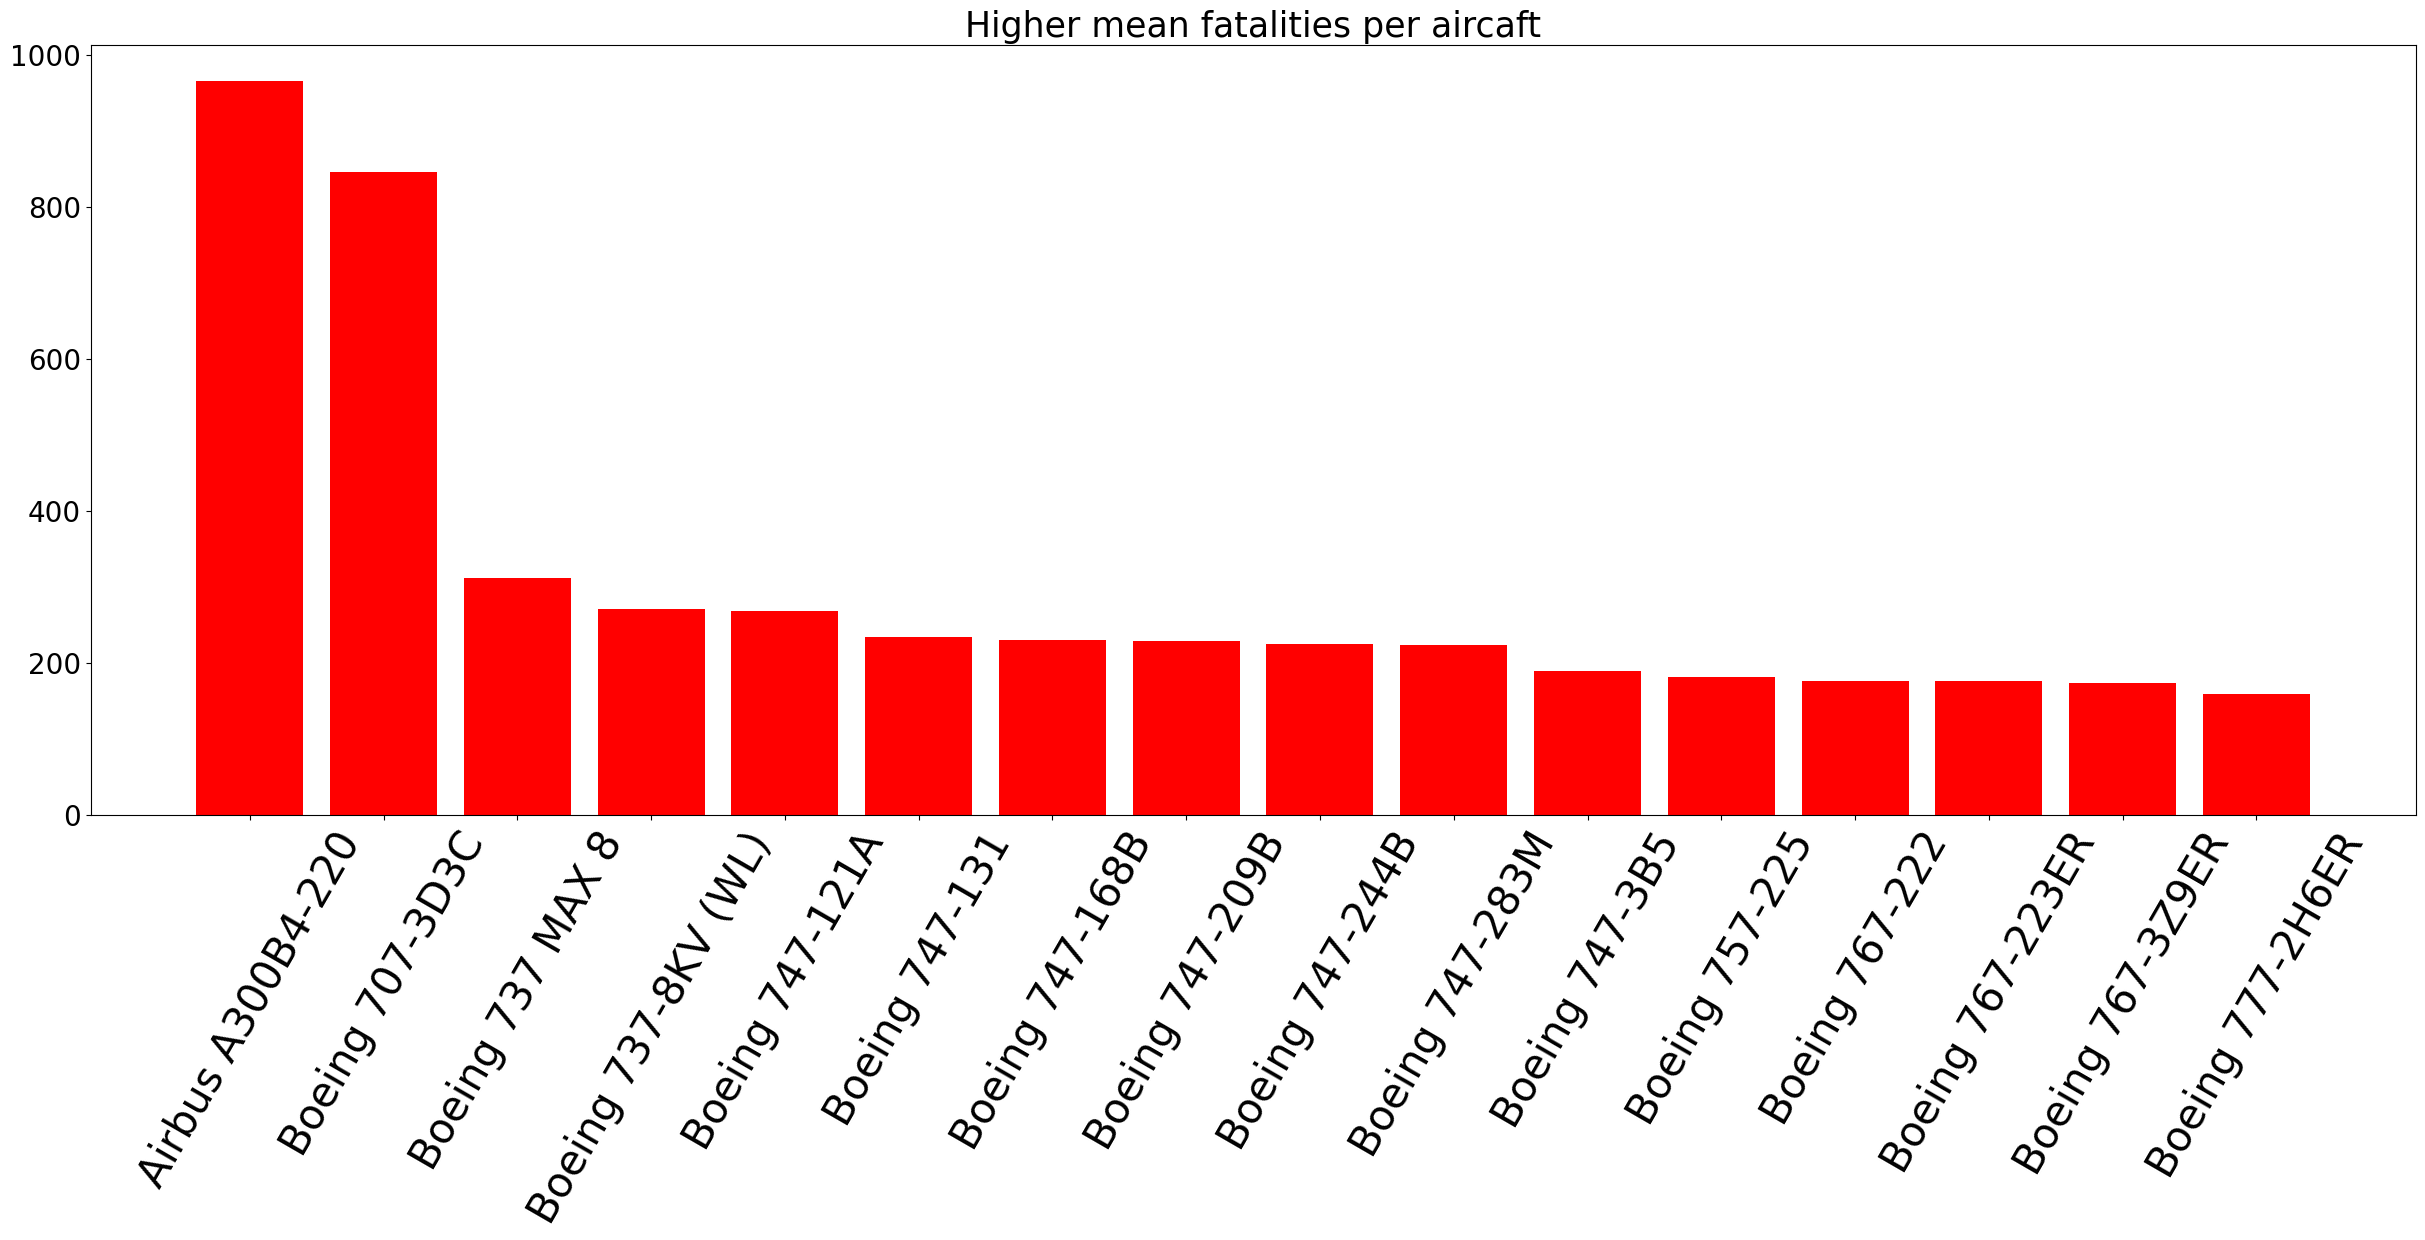

In [33]:
# Bar Chart
plt.rcParams["figure.figsize"] = [30, 10]
plt.bar(filtered_types["fatalities"].mean().index, filtered_types["fatalities"].mean().sort_values(ascending=False), color="red")
plt.xticks(fontsize=30, rotation=60)
plt.yticks(fontsize=20)
plt.title("Higher mean fatalities per aircaft", fontsize=25)
plt.show()

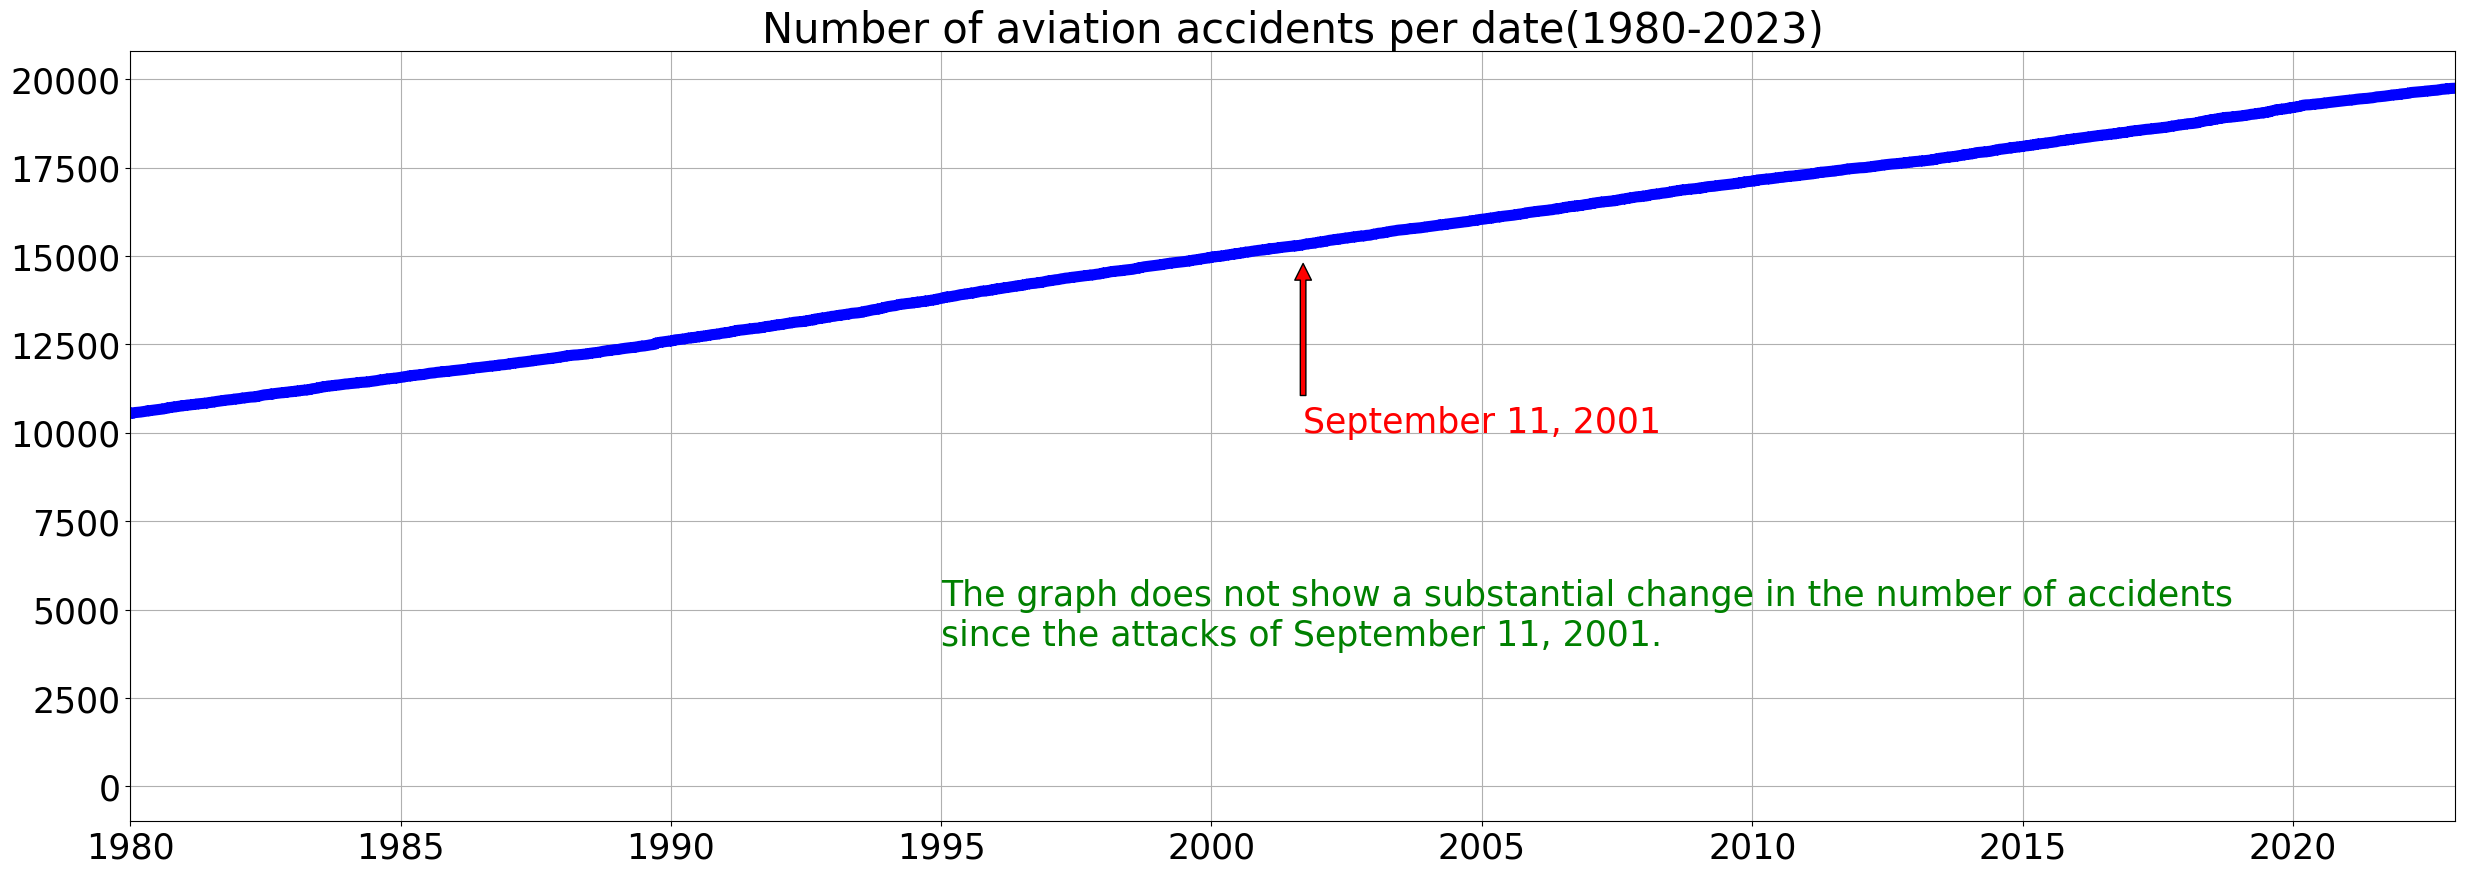

In [16]:
# Line Chart representing Number of aviation accidents from 1980 to 2023
from datetime import datetime
av_acc["row count"] = range(1, len(av_acc)+1)
plt.plot(av_acc["date"], av_acc["row count"], color="blue", lw=8)
plt.grid()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title("Number of aviation accidents per date(1980-2023)", fontsize=30)
plt.xlim(datetime(1980, 1, 1), datetime(2023,1,1))
plt.annotate("September 11, 2001", xy = (datetime(2001, 9, 11), 15000), xytext=(datetime(2001,9,11),10000), fontsize=25, c="red", arrowprops=dict(facecolor="red", shrink=0.05))
plt.text(datetime(1995,1,1), 4000, "The graph does not show a substantial change in the number of accidents\nsince the attacks of September 11, 2001.", fontsize=25, c="green")
plt.show()

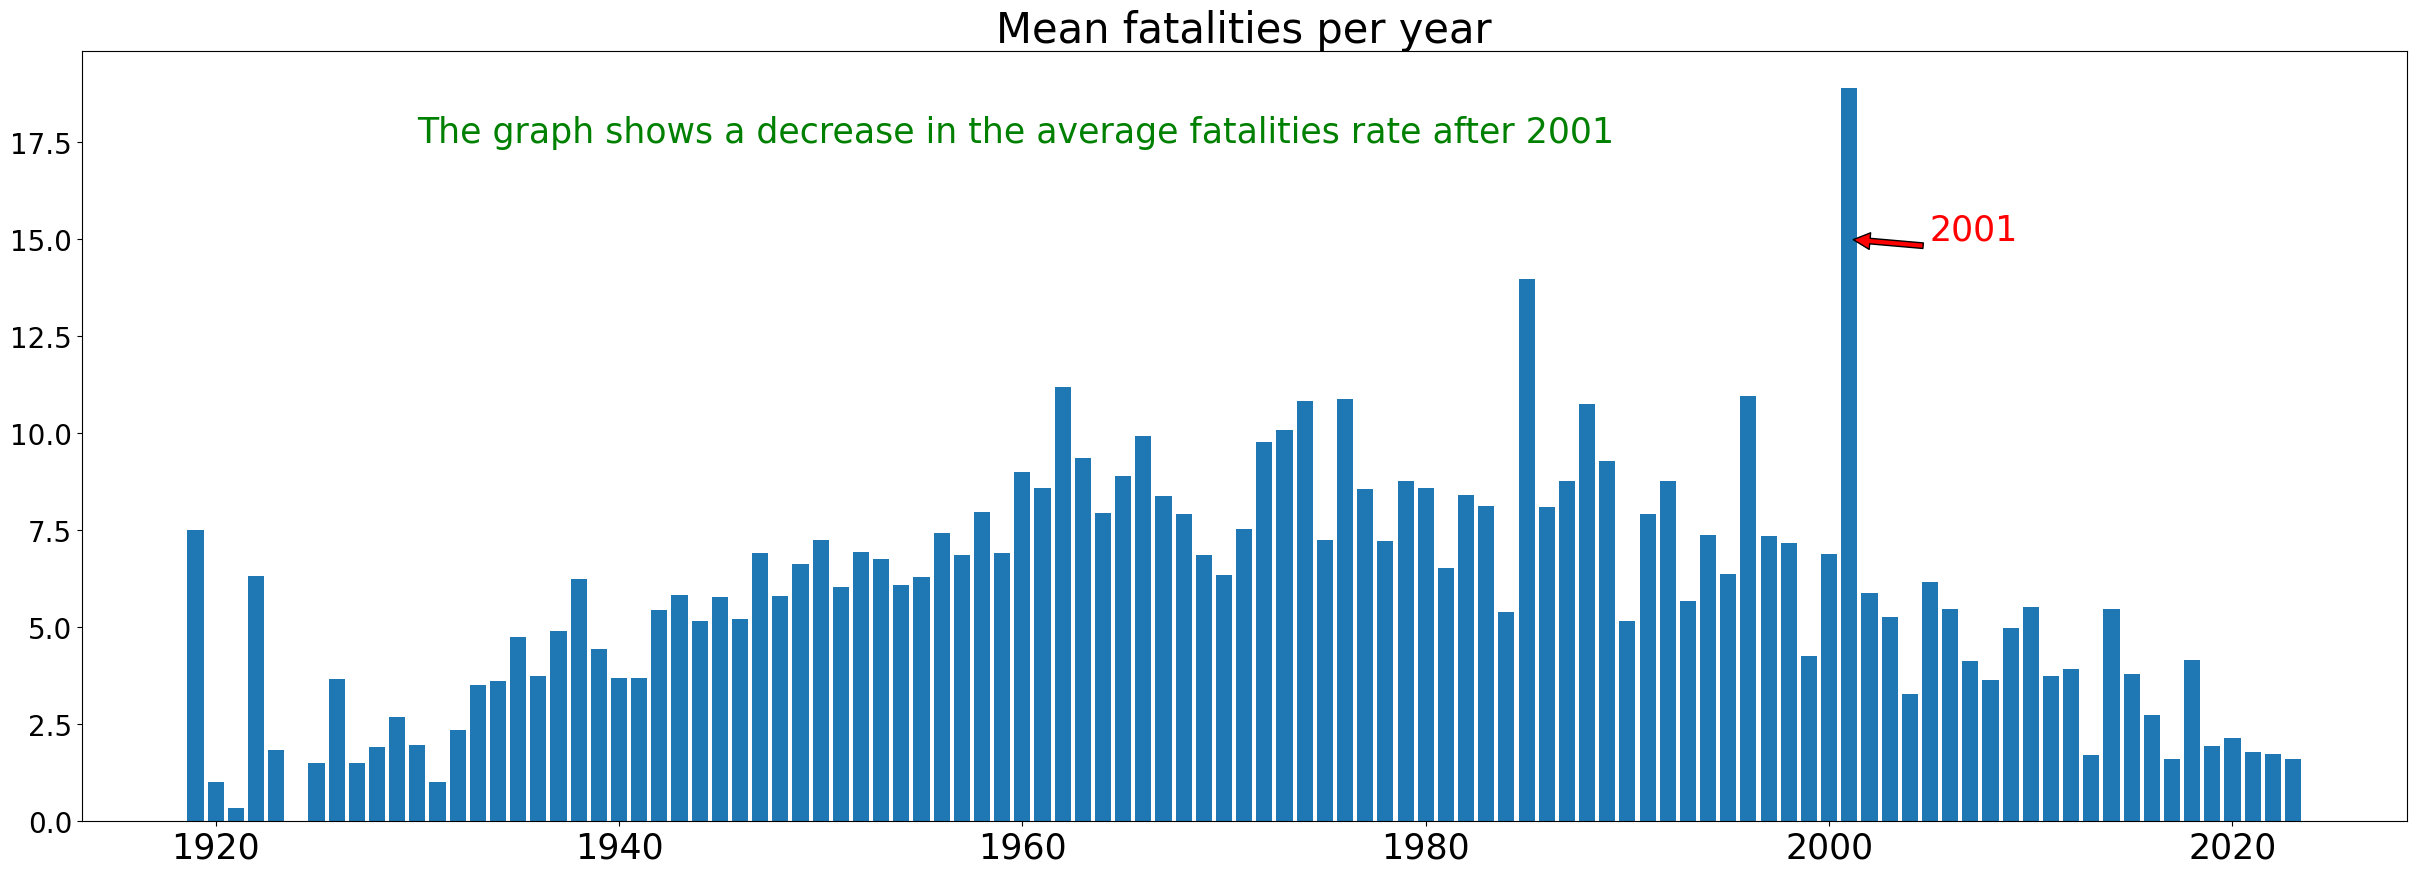

In [35]:
# Bar Chart representing Mean fatalities per year
years = av_acc.groupby(av_acc["date"].dt.year)
plt.bar(years["fatalities"].mean().index, years["fatalities"].mean().values)
plt.rcParams["figure.figsize"] = [30, 10]
plt.title("Mean fatalities per year", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=20)
plt.annotate("2001", xy=(2001, 15.0), xytext=(2005, 15.0), fontsize=25, c="red", arrowprops=dict(facecolor="red", shrink=0.05))
plt.text(1930, 17.5, "The graph shows a decrease in the average fatalities rate after 2001", fontsize=25, c="green")
plt.savefig("Mean_Fatalities_per_Year")
plt.show()